# (THIS IS A WORKING VERSION)

Author: Sungduk Yu\
Date: Wed 07 Jun 2023 10:09:28 AM PDT\
Description:\
This script calculates evaluation three metrics (MAE, R2, RMSE) based on daily-mean, horizontal-mean values of each variables.\

Input:
 - model_name: a string, model name
 - fn_x_true: npy file name for true input
 - fn_y_true: npy file name for true output
 - fn_y_pred: npy file name for model prediction
 - fn_grid: netcdif file name for grid information
 - fn_mli_mean, fn_mli_min, fn_mli_max: netcdf file names for input normalization coefficients (mean, min, max)
 - fn_mlo_scale: netcdf file name for output scaling coefficients.
 - fn_save_metrics: csv file name for saving output
 - fn_save_metrics_avg: csv file name for saving output (avg over the level dimension)

Output:
- calculated metrics as csv file "<model_name>.evaluation-metrics.csv"

# Change file names [user input here only!]

In [21]:
FN_MODEL_OUTPUT = {'MLP':  './model_outputs/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy',
                   'RPN':  './model_outputs/rpn_pred_v1_stride6.npy',
                   'CNN':  './model_outputs/val_predict_cnn_reshaped_stride6_FINAL.npy',
                   # 'cVAE': './model_outputs/cvae_preds_bestcrps.h5',
                   'cVAE': './model_outputs/cvae.h5',
                   'HSR': './model_outputs/hsr_preds_bestcrps.h5',
                  }

In [102]:
# model name
# (model name is used for the output)
model_name = 'HSR'

# input of validation dataset (npy)
fn_x_true = '../../npy_data_conversion/npy_files/val_input_stride6.npy'

# true output of validation dataset (npy)
fn_y_true = '../../npy_data_conversion/npy_files/val_target_stride6.npy'

# Model predicted output of varlidation dataset (npy)
fn_y_pred = FN_MODEL_OUTPUT[model_name]

# model grid information (nc)
fn_grid = '../../misc/E3SM-MMF_ne4_grid-info.nc'

# normalization scale factors (nc)
fn_mli_mean  = '../../norm_factors/mli_mean.nc'
fn_mli_min   = '../../norm_factors/mli_min.nc'
fn_mli_max   = '../../norm_factors/mli_max.nc'
fn_mlo_scale = '../../norm_factors/mlo_scale.nc'

# # fn_save_output
# fn_save_metrics = f'./metrics/{model_name}.metrics.csv'
# fn_save_metrics_avg = f'./metrics/{model_name}.metrics.lev-avg.csv'

# Set energy conversion scale factors

Energy unit conversion
 - "dT/dt" [K/s] * cp [J/kg/K] * dp/g [kg/m2]   -> [W/m2]
 - "dQ/dt" [kg/kg/s] * lv [J/kg] * dp/g [kg/m2] -> [W/m2]
 - "PRECC" [m/s] * lv [J/kg]  * rho_h2o [kg/m3] -> [W/m2] 
 
(for dT/dt and dQ/dt, it should be "dp/g-weighted" vertical integration, not vertical averaging.)

In [103]:
# physical constatns from (E3SM_ROOT/share/util/shr_const_mod.F90)
grav    = 9.80616    # acceleration of gravity ~ m/s^2
cp      = 1.00464e3  # specific heat of dry air   ~ J/kg/K
lv      = 2.501e6    # latent heat of evaporation ~ J/kg
lf      = 3.337e5    # latent heat of fusion      ~ J/kg
ls      = lv + lf    # latent heat of sublimation ~ J/kg
rho_air = 101325./ (6.02214e26*1.38065e-23/28.966) / 273.15 # density of dry air at STP  ~ kg/m^3
                                                            # ~ 1.2923182846924677
                                                            # SHR_CONST_PSTD/(SHR_CONST_RDAIR*SHR_CONST_TKFRZ)
                                                            # SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
                                                            # SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
rho_h20 = 1.e3       # density of fresh water     ~ kg/m^ 3

vars_mlo_energy_conv = {'ptend_t':cp,
                        'ptend_q0001':lv,
                        'cam_out_NETSW':1.,
                        'cam_out_FLWDS':1.,
                        'cam_out_PRECSC':lv*rho_h20,
                        'cam_out_PRECC':lv*rho_h20,
                        'cam_out_SOLS':1.,
                        'cam_out_SOLL':1.,
                        'cam_out_SOLSD':1.,
                        'cam_out_SOLLD':1.
                       }
# Vertical weighting (dp/g) is done in the main script as "dp" is not constant throughout samples.

# Main

In [104]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# set dimemsion names for xarray datasets
dim_name_level  = 'lev'
dim_name_sample = 'sample'

In [105]:
# load input dataset
x_true = np.load(fn_x_true).astype(np.float64)
y_true = np.load(fn_y_true).astype(np.float64)
if fn_y_pred[-3:] == '.h5':
    y_pred = xr.open_dataset(fn_y_pred)['pred'].values
else:
    y_pred = np.load(fn_y_pred).astype(np.float64)
N_samples = y_pred.shape[0] 

# load norm/scale factors
mlo_scale = xr.open_dataset(fn_mlo_scale)
mli_mean  = xr.open_dataset(fn_mli_mean)
mli_min   = xr.open_dataset(fn_mli_min)
mli_max   = xr.open_dataset(fn_mli_max)

In [106]:
# load grid information
ds_grid = xr.open_dataset(fn_grid) # has ncol:384
N_ncol = len(ds_grid['ncol']) # length of ncol dimension (nlat * nlon)

# make area-weights
ds_grid['area_wgt'] = ds_grid['area'] / ds_grid['area'].mean('ncol')

# map ds_grid's ncol dimension -> the N_samples dimension of npy-loayd arrays (e.g., y_pred)
to_xarray = {#'area'    : (dim_name_sample,np.tile(ds_grid['area'],     int(N_samples/len(ds_grid['ncol'])))),
             'area_wgt': (dim_name_sample,np.tile(ds_grid['area_wgt'], int(N_samples/len(ds_grid['ncol'])))),
             # 'lat':  (dim_name_sample,np.tile(ds_grid['lat'], int(N_samples/len(ds_grid['ncol'])))),
             # 'lon':  (dim_name_sample,np.tile(ds_grid['lon'], int(N_samples/len(ds_grid['ncol'])))),
            }
to_xarray = xr.Dataset(to_xarray)

# add nsample-mapped grid variables back to ds_grid
ds_grid = xr.merge([ds_grid  [['P0', 'hyai', 'hyam','hybi','hybm','lat','lon','area']],
                    to_xarray[['area_wgt']]])

## Pack np arrays to xarray dataset

In [107]:
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC',
            'cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD'] # mlo mean ML output.
vars_mlo_len = {'ptend_t':60,
                'ptend_q0001':60,
                'cam_out_NETSW':1,
                'cam_out_FLWDS':1,
                'cam_out_PRECSC':1,
                'cam_out_PRECC':1,
                'cam_out_SOLS':1,
                'cam_out_SOLL':1,
                'cam_out_SOLSD':1,
                'cam_out_SOLLD':1
               }
len_to_dim = {60:dim_name_level,
              N_samples: dim_name_sample}

In [108]:
DS = {}

for kds in ['true', 'pred']:
    if kds=='true':
        work = y_true
    elif kds=='pred':
        work = y_pred

    # [1] Construct dictionary for xarray dataset
    #     format is key for variable name /
    #               value for a turple of (dimension names, data).
    to_xarray = {}
    for k, kvar in enumerate(vars_mlo):

        # length of variable (ie, number of levels)
        kvar_len = vars_mlo_len[kvar]

        # set dimensions of variable
        if kvar_len == 60:
            kvar_dims = (dim_name_sample, dim_name_level)
        elif kvar_len == 1:
            kvar_dims = dim_name_sample

        # set start and end indices of variable in the loaded numpy array
        # then, add 'kvar':(kvar_dims, <np_array>) to dictionary
        if k==0: ind1=0
        ind2 = ind1 + kvar_len

        # scaled output
        kvar_data = np.squeeze(work[:,ind1:ind2])
        # unscaled output
        kvar_data = kvar_data / mlo_scale[kvar].values

        to_xarray[kvar] = (kvar_dims, kvar_data)

        ind1 = ind2

    # [2] convert dict to xarray dataset
    DS[kds] = xr.Dataset(to_xarray)

    # [3] add surface pressure ('state_ps') from ml input
    # normalized ps
    state_ps =  xr.DataArray(x_true[:,120], dims=('sample'), name='state_ps')
    # unnormalized ps
    state_ps = state_ps * (mli_max['state_ps'] - mli_min['state_ps']) + mli_mean['state_ps']
    DS[kds]['state_ps'] = state_ps

    # [4] add grid information
    DS[kds] = xr.merge([DS[kds], ds_grid])

    # [5] add pressure thickness of each level, dp
    tmp = DS[kds]['P0']*DS[kds]['hyai'] + DS[kds]['state_ps']*DS[kds]['hybi']
    tmp = tmp.isel(ilev=slice(1,61)).values - tmp.isel(ilev=slice(0,60)).values
    tmp = tmp.transpose()
    DS[kds]['dp'] = xr.DataArray(tmp, dims=('sample', 'lev'))

    # [6] break (sample) to (ncol,time)
    N_timestep = int(N_samples/N_ncol)
    dim_ncol     = np.arange(N_ncol)
    dim_timestep = np.arange(N_timestep)
    new_ind = pd.MultiIndex.from_product([dim_timestep, dim_ncol],
                                         names=['time', 'ncol'])
    DS[kds] = DS[kds].assign_coords(sample=new_ind).unstack('sample')

del work, to_xarray, y_true, y_pred, x_true, state_ps, tmp

## 1) Converting variable units to common energy unit [W/m2] 
- no vertical summation for ptend variables
- no horizontal mean 
- no daily mean

In [109]:
DS_ENERGY = {}
for kds in ['true','pred']:
    # Make a copy to keep original dataset
    DS_ENERGY[kds] = DS[kds].copy(deep=True)

    # vertical weighting / area weighting / unit conversion
    for kvar in vars_mlo:

        # [1] weight vertical levels by dp/g
        #     ONLY for vertically-resolved variables, e.g., ptend_{t,q0001}
        # dp/g = - \rho * dz
        if vars_mlo_len[kvar] == 60:
            DS_ENERGY[kds][kvar] = DS_ENERGY[kds][kvar] * DS_ENERGY[kds]['dp']/grav

        if True:
            # [2] weight area
            #     for ALL variables
            DS_ENERGY[kds][kvar] = DS_ENERGY[kds]['area_wgt'] * DS_ENERGY[kds][kvar]

        # [3] convert units to W/m2
        #     for variables with different units, e.g., ptend_{t,q0001}, precsc, precc
        DS_ENERGY[kds][kvar] =  vars_mlo_energy_conv[kvar] * DS_ENERGY[kds][kvar]

    # # subset only model output variables
    # DS_ENERGY[kds] = DS_ENERGY[kds][vars_mlo]

#### DS_ENERGY zonal mean version

In [110]:
# R2 after zonal mean, daily mean
DS_ENERGY_zm = {}
# bins_lat = np.arange(-90,90,5)
lat = np.unique(ds_grid['lat'].values)
latdiff = np.diff(lat)
lat_tf = latdiff>0.1
lat_tf = np.concatenate([lat_tf, [True]])
lat = lat[lat_tf]
bins_lat = np.concatenate([[-90], lat, [90]])


for kds in ['true', 'pred']:
    DS_ENERGY_zm[kds] = DS_ENERGY[kds].coarsen(time=12).mean()
    DS_ENERGY_zm[kds] = DS_ENERGY_zm[kds].groupby_bins(DS_ENERGY_zm[kds]['lat'],bins=bins_lat).mean()
    DS_ENERGY_zm[kds] = DS_ENERGY_zm[kds][vars_mlo]


# calculate metrics on (daily-averaged, globally-averaged values)
Metrics_zm = {}
Metrics_zm['MAE']  = (np.abs(DS_ENERGY_zm['true']   - DS_ENERGY_zm['pred'])).mean('time')
Metrics_zm['RMSE'] = np.sqrt(((DS_ENERGY_zm['true'] - DS_ENERGY_zm['pred'])**2.).mean('time'))
Metrics_zm['R2']   = 1 - ((DS_ENERGY_zm['true'] - DS_ENERGY_zm['pred']                    )**2.).sum('time')/\
                         ((DS_ENERGY_zm['true'] - DS_ENERGY_zm['true'].mean('time'))**2.).sum('time')

# # f_save
# # save the output
# Metrics_zm['R2']['lat_bins'] =     np.array([ k.values.item().mid for k in Metrics_zm['MAE']['lat_bins'] ])
# Metrics_zm['R2'] = Metrics_zm['R2'].rename({'lat_bins':'lat'})

# f_save = f'./metrics/{model_name}_R2_zonal-mean-in-the-beginning.nc'
# Metrics_zm['R2'].to_netcdf(f_save)

# Metrics_zm['R2']['ptend_t'].plot(vmin=0,vmax=1)


#### SAVE for bar plots ####

# average through levels
Metrics_vert_avg = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    Metrics_vert_avg[kmetric] = Metrics_zm[kmetric].mean(['lat_bins','lev'])

# save the output
work = pd.DataFrame({'MAE':  Metrics_vert_avg['MAE'].to_pandas(),
                     'RMSE': Metrics_vert_avg['RMSE'].to_pandas(),
                     'R2':   Metrics_vert_avg['R2'].to_pandas()}
                    )
work.index.name = 'Variable'
f_save = f'./metrics/{model_name}_scalar-metric_zonal-mean-in-the-beginning.csv'
work.to_csv(f_save)

# flattend variables
Metrics_stacked = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    Metrics_stacked[kmetric] = Metrics_zm[kmetric].mean('lat_bins')\
                                                  .to_stacked_array('ml_out_idx', sample_dims='', name=kmetric)


# save the output
work = pd.DataFrame({'MAE':  Metrics_stacked['MAE'].values,
                     'RMSE': Metrics_stacked['RMSE'].values,
                     'R2':   Metrics_stacked['R2'].values}
                    )
work.index.name = 'output_idx'
f_save = f'./metrics/{model_name}_lev-metric_zonal-mean-in-the-beginning.csv'
work.to_csv(f_save)


# del Metrics_zm, Metrics_vert_avg, Metrics_stacked, f_save, work

## Calculate metrics based on globally-averaged model output

In [111]:
all_metrics = ['MAE','RMSE','R2']
q_lev_clip = 12 # how many top layers to be clipped for ptend_q

In [112]:
# calculate metrics on (daily-averaged, globally-averaged values)

# this is 3d (ptend)

DS_ENERGY[kds] = DS_ENERGY[kds][vars_mlo]

Metrics = {}
Metrics['MAE']  = (np.abs(DS_ENERGY['true']   - DS_ENERGY['pred'])).mean('time')
Metrics['RMSE'] = np.sqrt(((DS_ENERGY['true'] - DS_ENERGY['pred'])**2.).mean('time'))
Metrics['R2'] = 1 - ((DS_ENERGY['true'] - DS_ENERGY['pred']                    )**2.).sum('time')/\
                    ((DS_ENERGY['true'] - DS_ENERGY['true'].mean('time'))**2.).sum('time')

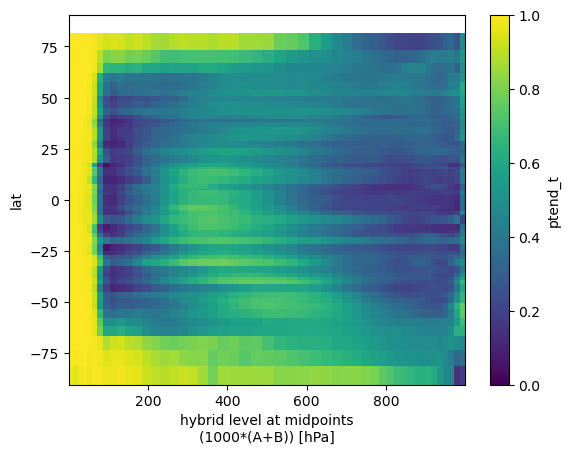

In [113]:
# Make zonal mean

# this is 2d (ptend)

Metrics_zm = {}
Metrics_zm['R2'] = Metrics['R2'].copy(deep=True)
Metrics_zm['R2']['lat'] = ds_grid['lat']
Metrics_zm['R2'] = Metrics_zm['R2'].groupby_bins(Metrics_zm['R2']['lat'],bins=bins_lat).mean()
Metrics_zm['R2']['lat_bins'] =  np.array([ k.values.item().mid for k in Metrics_zm['R2']['lat_bins'] ])
del Metrics_zm['R2']['lat']
Metrics_zm['R2'] = Metrics_zm['R2'].rename({'lat_bins':'lat'})

# save
f_save = f'./metrics/{model_name}_R2_zonal-mean-at-the-end.nc'
Metrics_zm['R2'].to_netcdf(f_save)

Metrics_zm['R2']['ptend_t'].plot(vmin=0,vmax=1)

del Metrics_zm

In [114]:
# horizontal mean

# this is 1 d (ptend)

for kmetric in all_metrics:
    Metrics[kmetric] = Metrics[kmetric].mean('ncol') # simple mean

# remove levels [1,12] for ptend_q0001
for kmetric in all_metrics:
    Metrics[kmetric]['ptend_q0001'] = Metrics[kmetric]['ptend_q0001'].isel(lev=slice(q_lev_clip,60)).rename({'lev':'lev_clipped'})

In [115]:
# average through levels
Metrics_vert_avg = {}
for kmetric in all_metrics:
    Metrics_vert_avg[kmetric] = Metrics[kmetric].mean('lev')
    Metrics_vert_avg[kmetric] = Metrics_vert_avg[kmetric].mean('lev_clipped')
    Metrics_vert_avg[kmetric] = Metrics_vert_avg[kmetric].mean('ilev') # remove dummy dim

# save the output
work = pd.DataFrame({'MAE':  Metrics_vert_avg['MAE'].to_pandas(),
                     'RMSE': Metrics_vert_avg['RMSE'].to_pandas(),
                     'R2':   Metrics_vert_avg['R2'].to_pandas()}
                    )
work.index.name = 'Variable'

if q_lev_clip!=0:
    tmpstr = f'clip-lev{q_lev_clip}.'
else:
    tmpstr = ''
    
fn_save_metrics_avg = f'./metrics/{model_name}.metrics.lev-avg.{tmpstr}csv'
work.to_csv(fn_save_metrics_avg)
work

,MAE,RMSE,R2
Variable,,,
ptend_t,2.844789,4.824681,5.675242e-01
ptend_q0001,5.980033,9.868877,-1.785535e+05
cam_out_NETSW,19.816968,37.773021,9.591362e-01
cam_out_FLWDS,6.266635,8.219851,9.041154e-01
cam_out_PRECSC,3.511187,6.094945,-inf
cam_out_PRECC,42.379195,90.640413,-6.834750e+01
cam_out_SOLS,11.314418,23.614025,9.287765e-01
cam_out_SOLL,13.602789,27.778324,9.161431e-01
cam_out_SOLSD,6.330680,12.395840,9.226213e-01


In [116]:
# flattend variables
Metrics_stacked = {}
for kmetric in all_metrics:
    Metrics_stacked[kmetric] = Metrics[kmetric].to_stacked_array('ml_out_idx', sample_dims='', name=kmetric)


# save the output
work = pd.DataFrame({'MAE':  Metrics_stacked['MAE'].values,
                     'RMSE': Metrics_stacked['RMSE'].values,
                     'R2':   Metrics_stacked['R2'].values}
                    )
work.index.name = 'output_idx'

fn_save_metrics = f'./metrics/{model_name}.metrics.{tmpstr}csv'
work.to_csv(fn_save_metrics)
work

,MAE,RMSE,R2
output_idx,,,
0,0.002911,0.007718,0.802508
1,0.002330,0.008130,0.948326
2,0.004642,0.009602,0.976772
3,0.006368,0.010444,0.991807
4,0.010196,0.013531,0.998713
...,...,...,...
111,42.379195,90.640413,-68.347502
112,11.314418,23.614025,0.928777
113,13.602789,27.778324,0.916143


In [117]:
!ls metrics -lht|head -20

total 2.3M
-rw-rw---- 1 sungduk m4331 6.9K Jun  7 01:10 HSR.metrics.clip-lev{q_lev_clip}.csv
-rw-rw---- 1 sungduk m4331  694 Jun  7 01:10 HSR.metrics.lev-avg.clip-lev{q_lev_clip}.csv
-rw-rw---- 1 sungduk m4331  74K Jun  7 01:10 HSR_R2_zonal-mean-at-the-end.nc
-rw-rw---- 1 sungduk m4331 7.6K Jun  7 01:09 HSR_lev-metric_zonal-mean-in-the-beginning.csv
-rw-rw---- 1 sungduk m4331  685 Jun  7 01:09 HSR_scalar-metric_zonal-mean-in-the-beginning.csv
-rw-rw---- 1 sungduk m4331 6.9K Jun  7 01:08 cVAE.metrics.clip-lev{q_lev_clip}.csv
-rw-rw---- 1 sungduk m4331  697 Jun  7 01:08 cVAE.metrics.lev-avg.clip-lev{q_lev_clip}.csv
-rw-rw---- 1 sungduk m4331  74K Jun  7 01:08 cVAE_R2_zonal-mean-at-the-end.nc
-rw-rw---- 1 sungduk m4331 7.6K Jun  7 01:08 cVAE_lev-metric_zonal-mean-in-the-beginning.csv
-rw-rw---- 1 sungduk m4331  683 Jun  7 01:08 cVAE_scalar-metric_zonal-mean-in-the-beginning.csv
-rw-rw---- 1 sungduk m4331 6.8K Jun  7 01:07 CNN.metrics.clip-lev{q_lev_clip}.csv
-rw-rw---- 1 sungduk m4331  69

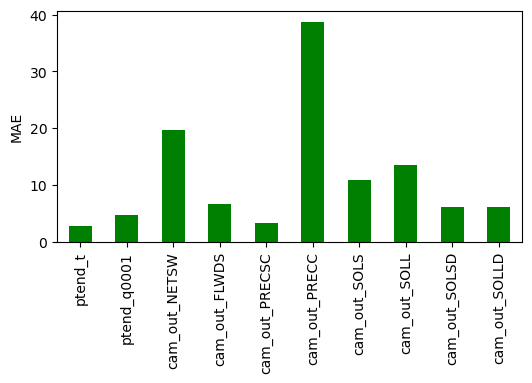

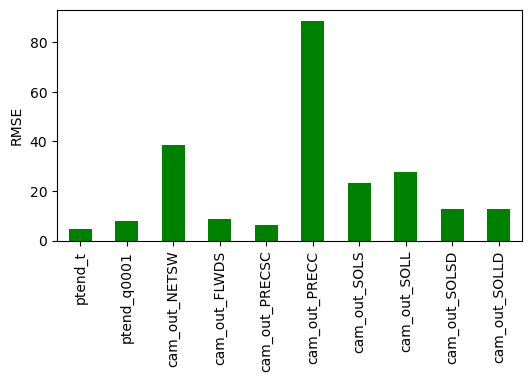

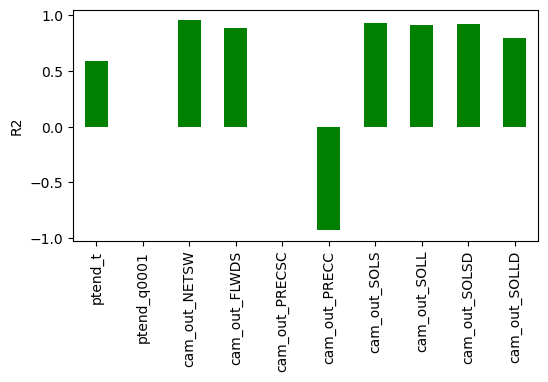

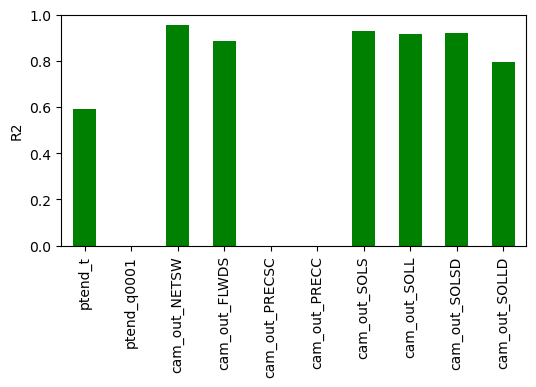

In [384]:
for kmetric in all_metrics:
    fig, ax = plt.subplots()
    Metrics_vert_avg[kmetric].to_pandas().plot.bar(color='green', ax=ax)
    ax.set_ylabel(kmetric)
    fig.set_size_inches(6,3)

for kmetric in ['R2']:
    fig, ax = plt.subplots()
    Metrics_vert_avg[kmetric].to_pandas().plot.bar(color='green', ax=ax)
    ax.set_ylabel(kmetric)
    ax.set_ylim(0,1)
    fig.set_size_inches(6,3)

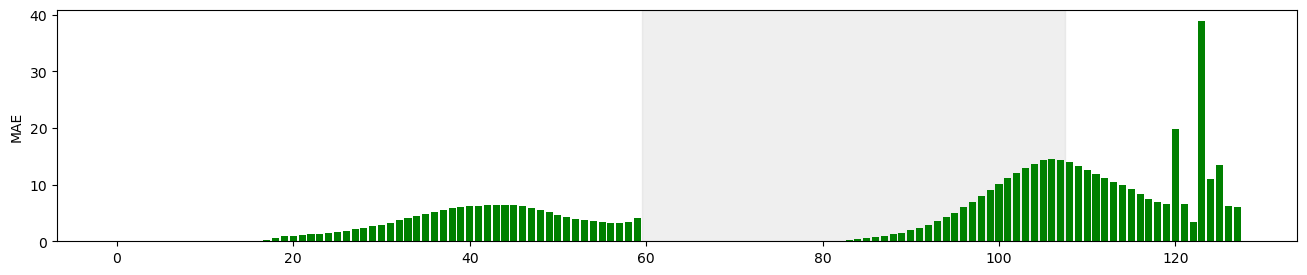

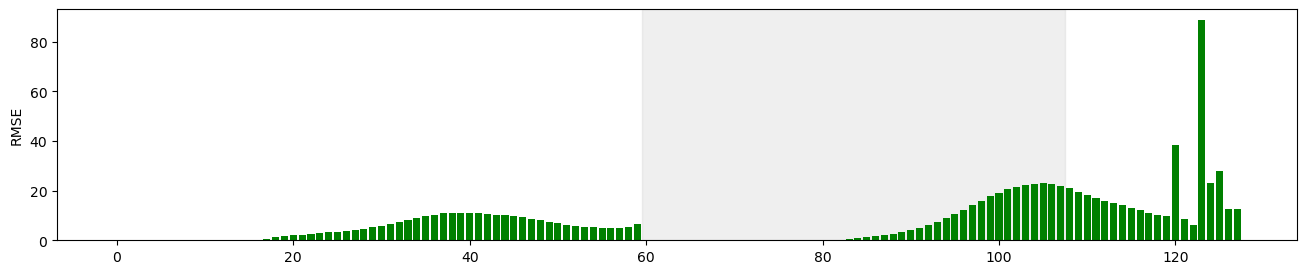

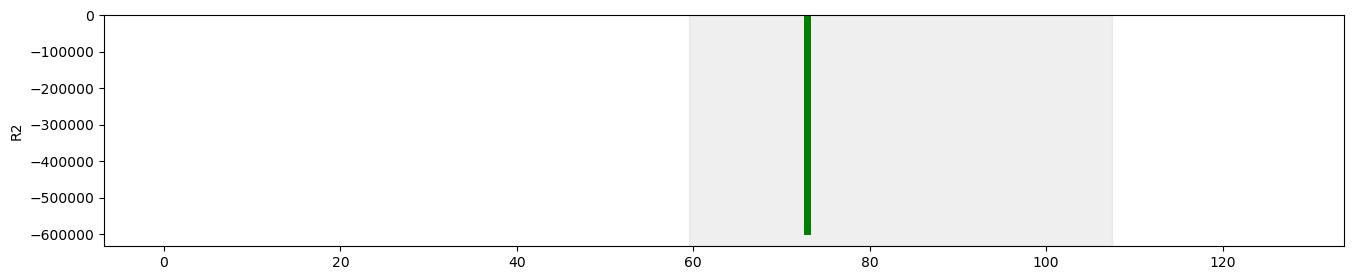

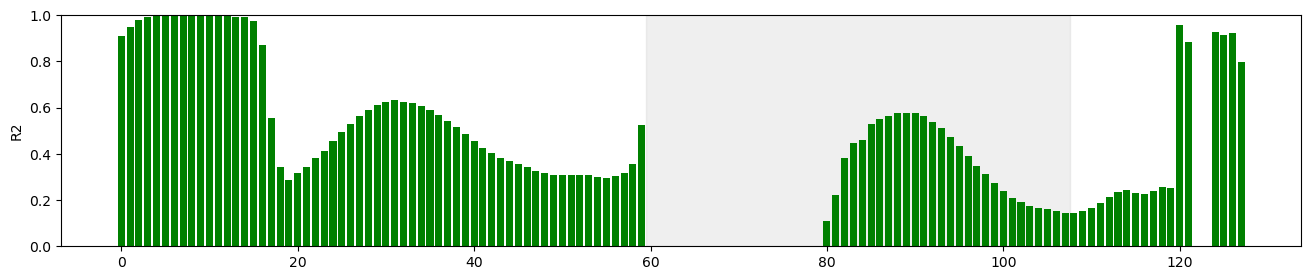

In [385]:
for kmetric in all_metrics:
    fig, ax = plt.subplots()
    ploty = Metrics_stacked[kmetric].values
    plotx = np.arange(len(ploty))
    ax.bar(plotx,ploty, color='g')
    ax.set_ylabel(kmetric)
    fig.set_size_inches(16,3)

    ax.axvspan(60-0.5,60+48-0.5, color='silver', alpha=.25, zorder=-1)


for kmetric in ['R2']:
    fig, ax = plt.subplots()
    ploty = Metrics_stacked[kmetric].values
    plotx = np.arange(len(ploty))
    ax.bar(plotx,ploty, color='g')
    tmp = ax.get_ylim()
    ax.set_ylim(0,1)
    ax.set_ylabel(kmetric)
    fig.set_size_inches(16,3)
    
    ax.axvspan(60-0.5,60+48-0.5, color='silver', alpha=.25, zorder=-1)


    
    

# Plot (intercomparison)

In [8]:

### This for metrics calculated withoout averaging. ###
# file names for saved metrics (level-avg'ed)
fn_metrics = {'CNN':  './metrics/CNN.metrics.lev-avg.csv',
              'MLP':  './metrics/MLP.metrics.lev-avg.csv',
              'RPN':  './metrics/RPN.metrics.lev-avg.csv',
              'cVAE': './metrics/cVAE.metrics.lev-avg.csv',
              'HSR':  './metrics/HSR.metrics.lev-avg.csv',
             }

# file names for saved metrics (not level_avg'ed)
fn_metrics_stacked = {'CNN':  './metrics/CNN.metrics.csv',
                      'MLP':  './metrics/MLP.metrics.csv',
                      'RPN':  './metrics/RPN.metrics.csv',
                      'cVAE': './metrics/cVAE.metrics.csv',
                      'HSR':  './metrics/HSR.metrics.csv',
                     }
###

# ### This for metrics calculated on daily-mean, zonal-mean ###
# fn_metrics = {'CNN':  './metrics/CNN_scalar-metric_zonal-mean-in-the-beginning.nc', # wrong extention. should be csv not nc. typo in the code.
#               'MLP':  './metrics/MLP_scalar-metric_zonal-mean-in-the-beginning.nc',
#               'RPN':  './metrics/RPN_scalar-metric_zonal-mean-in-the-beginning.nc',
#               'cVAE': './metrics/cVAE_scalar-metric_zonal-mean-in-the-beginning.nc',
#               'HSR':  './metrics/HSR_scalar-metric_zonal-mean-in-the-beginning.nc',
#              }

# # file names for saved metrics (not level_avg'ed)
# fn_metrics_stacked = {'CNN':  './metrics/CNN_lev-metric_zonal-mean-in-the-beginning.nc',
#                       'MLP':  './metrics/MLP_lev-metric_zonal-mean-in-the-beginning.nc',
#                       'RPN':  './metrics/RPN_lev-metric_zonal-mean-in-the-beginning.nc',
#                       'cVAE': './metrics/cVAE_lev-metric_zonal-mean-in-the-beginning.nc',
#                       'HSR':  './metrics/HSR_lev-metric_zonal-mean-in-the-beginning.nc',
#                      }
# ###

# bar colors
# https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7
lc_model = {'CNN':  '#0072B2',
            'HSR':  '#E69F00',
            'MLP':  '#882255',
            'RPN':  '#009E73',
            'cVAE': '#D55E00',
           }

# variable short name
var_short_name = {'ptend_t': 'dT/dt',
                  'ptend_q0001':'dq/dt',
                  'cam_out_NETSW':  'NETSW',
                  'cam_out_FLWDS':  'FLWDS',
                  'cam_out_PRECSC': 'PRECSC',
                  'cam_out_PRECC': 'PRECC',
                  'cam_out_SOLS': 'SOLS',
                  'cam_out_SOLL': 'SOLL',
                  'cam_out_SOLSD': 'SOLSD',
                  'cam_out_SOLLD': 'SOLLD',
                 }

### plot 1. lev-aggregated

In [9]:
# tell which models and which metrics you want to plot
plot_this_models = ['CNN','HSR','MLP','RPN','cVAE']
plot_this_metrics = ['MAE', 'RMSE']

In [10]:
PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )

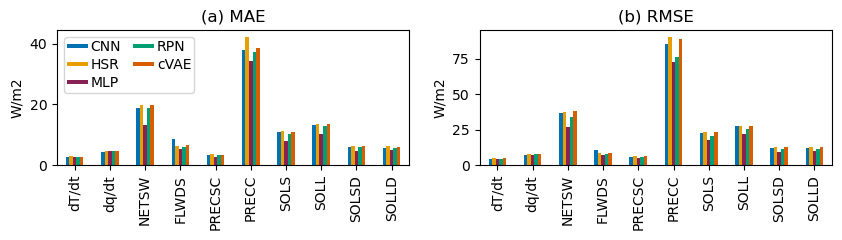

In [11]:
abc='abcdefg'
fig, _ax = plt.subplots(ncols=len(plot_this_metrics))
for k, kmetric in enumerate(plot_this_metrics):
    ax = _ax[k]
    plotdata = PLOTDATA_by_METRIC[kmetric]
    plotdata = plotdata.rename(columns=var_short_name)
    plotdata = plotdata.transpose()
    plotdata.plot.bar(color=[lc_model[kmodel] for kmodel in plot_this_models],
                      legend = False,
                      ax=ax)
    ax.set_xlabel('')
    ax.set_title(f'({abc[k]}) {kmetric}')
    ax.set_ylabel('W/m2')

    fig.set_size_inches(10,1.75)

_ax[0].legend(ncols=2, columnspacing=.9, labelspacing=.3,
              handleheight=.07, handlelength=1.5, handletextpad=.2,
              borderpad=.2,
              loc='upper left')

### plot 2. vertical profile for ptends

In [12]:
# tell which models and which metrics you want to plot
plot_this_models = ['CNN','HSR','MLP','RPN','cVAE']
plot_this_metrics = ['MAE', 'RMSE', 'R2']

In [13]:
# map 'output_idx' and 'variables'
var_idx = {}
var_idx['ptend_t'] = (0,60)
var_idx['ptend_q0001'] = (60,60+48)

In [14]:
PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics_stacked[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )


NameError: name 'q_lev_clip' is not defined

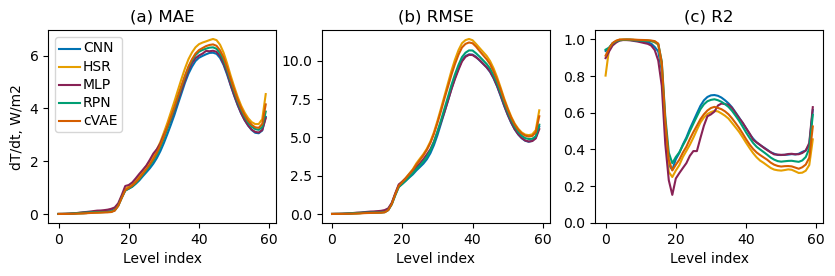

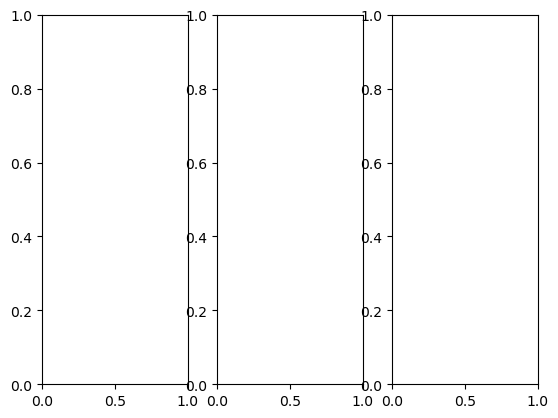

In [15]:
abc='abcdefg'
for kvar in ['ptend_t','ptend_q0001']:
    fig, _ax = plt.subplots(ncols=len(plot_this_metrics))
    for k, kmetric in enumerate(plot_this_metrics):
        ax = _ax[k]
        idx_start = var_idx[kvar][0]
        idx_end = var_idx[kvar][1]
        plotdata = PLOTDATA_by_METRIC[kmetric].iloc[:,idx_start:idx_end]
        if plotdata.columns[0] > 1:
            plotdata.columns = plotdata.columns - 60 + q_lev_clip
        plotdata.transpose()\
        .plot(color=[lc_model[kmodel] for kmodel in plot_this_models],
              legend=False,
              ax=ax,
             )

        ax.set_xlabel('Level index')
        ax.set_title(f'({abc[k]}) {kmetric}')
        if k==0:
            ax.set_ylabel(f'{var_short_name[kvar]}, W/m2')
        else:
            ax.set_ylabel('')
        fig.set_size_inches(10,2.5)

        # R2 ylim
        if  (kmetric=='R2'):
            ax.set_ylim(0,1.05)

    # legend
    _ax[0].legend(ncols=1, labelspacing=.3,
              handleheight=.07, handlelength=1.5, handletextpad=.2,
              borderpad=.3,
              loc='upper left')

### plot 3

/tmp/ipykernel_243356/12085827.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/ipykernel_243356/12085827.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/ipykernel_243356/12085827.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


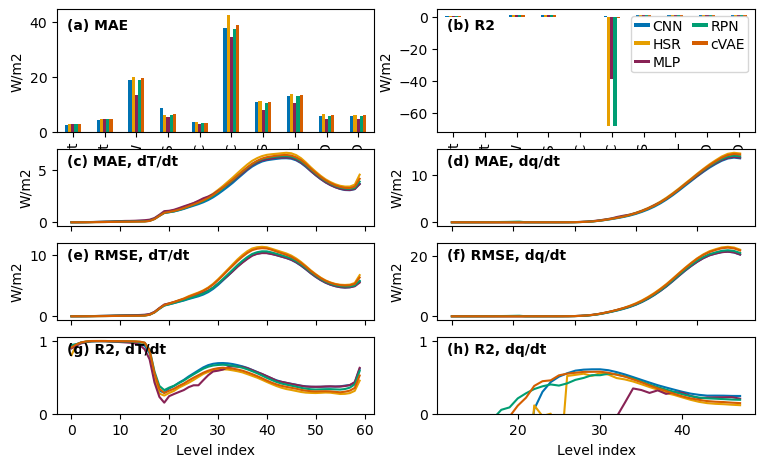

In [394]:
sw_log = False

abc='abcdefghij'
fig, _ax = plt.subplots(ncols=2, nrows=4,
                        gridspec_kw={'height_ratios': [1.6,1,1,1]})

# top rows

plot_this_models = ['CNN','HSR','MLP','RPN','cVAE']
plot_this_metrics = ['MAE', 'R2']

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )

for k, kmetric in enumerate(plot_this_metrics):
    ax = _ax[0,k]
    plotdata = PLOTDATA_by_METRIC[kmetric]
    plotdata = plotdata.rename(columns=var_short_name)
    plotdata = plotdata.transpose()
    plotdata.plot.bar(color=[lc_model[kmodel] for kmodel in plot_this_models],
                      legend = False,
                      ax=ax)
    ax.set_xlabel('')
    # ax.set_title(f'({abc[k]}) {kmetric}')
    ax.set_ylabel('W/m2')

    ax.text(0.03, 0.93, f'({abc[k]}) {kmetric}', horizontalalignment='left',
           verticalalignment='top', transform=ax.transAxes,
           fontweight='demi')

    if sw_log:
        ax.set_yscale('log')

_ax[0,1].legend(ncols=2, columnspacing=.6, labelspacing=.3,
              handleheight=.05, handlelength=1.15, handletextpad=.2,
              borderpad=.2,
              frameon=True,
              loc='upper right')

# bottom rows

plot_this_models = ['CNN','HSR','MLP','RPN','cVAE']
plot_this_metrics = ['MAE', 'RMSE', 'R2']

var_idx = {}
var_idx['ptend_t'] = (0,60)
var_idx['ptend_q0001'] = (60,60+48)

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics_stacked[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )


for kk, kvar in enumerate(['ptend_t','ptend_q0001']):
    for k, kmetric in enumerate(plot_this_metrics):
        ax = _ax[k+1, 0 if kvar=='ptend_t' else 1]
        idx_start = var_idx[kvar][0]
        idx_end = var_idx[kvar][1]
        plotdata = PLOTDATA_by_METRIC[kmetric].iloc[:,idx_start:idx_end]
        if plotdata.columns[0] > 1:
            plotdata.columns = plotdata.columns - 60 + q_lev_clip
        plotdata.transpose()\
        .plot(color=[lc_model[kmodel] for kmodel in plot_this_models],
              legend=False,
              ax=ax,
             )


        #ax.set_title(f'({abc[k]}) {kmetric}')
        if k==0 or k==1:
            ax.set_ylabel(f'W/m2')
            ax.set_xticklabels([''])
            ax.set_xlabel('')
        else:
            ax.set_ylabel('')
            ax.set_xlabel('Level index')


        ax.text(0.03, 0.93, f'({abc[kk+2*k+2]}) {kmetric}, {var_short_name[kvar]}', horizontalalignment='left',
               verticalalignment='top', transform=ax.transAxes,
               fontweight='demi')

        if sw_log:
            ax.set_yscale('log')

        # R2 ylim
        if  (kmetric=='R2'):
            ax.set_ylim(0,1.05)


    # # legend
    # _ax[0].legend(ncols=1, labelspacing=.3,
    #           handleheight=.07, handlelength=1.5, handletextpad=.2,
    #           borderpad=.3,
    #           loc='upper left')

fig.set_size_inches(9,1.75*3)

### plot 4

/tmp/ipykernel_243356/1314481925.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata.loc[:,plotdata.columns<=idx_chg] = np.log10( plotdata.loc[:,plotdata.columns<=idx_chg] )
/tmp/ipykernel_243356/1314481925.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/ipykernel_243356/1314481925.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata.loc[:,plotdata.columns<=idx_chg] = np.log10( plotdata.loc[:,plotdata.columns<=idx_chg] )
/tmp/ipykernel_243356/1314481925.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator

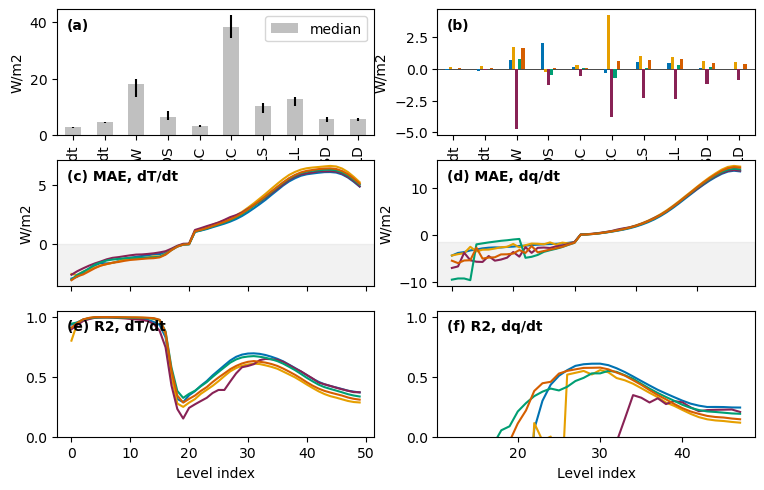

In [395]:
sw_log = False

abc='abcdefghij'
fig, _ax = plt.subplots(ncols=2, nrows=3,
                        gridspec_kw={'height_ratios': [1,1,1]})

# top rows

plot_this_models = ['CNN','HSR','MLP','RPN','cVAE']
plot_this_metrics = ['MAE']

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )

ax = _ax[0,0]
plotdata = PLOTDATA_by_METRIC['MAE']
plotdata = plotdata.rename(columns=var_short_name)
plotdata = plotdata.transpose()
plotdata['median'] = plotdata.mean(axis=1)  # make sure this is median or mean
plotdata['min'] = - plotdata.min(axis=1) + plotdata['median']
plotdata['max'] =   plotdata.max(axis=1) - plotdata['median']
plotdata.plot(kind='bar',
              y='median',
              yerr=plotdata[['min','max']].transpose().values,
              color='silver',
              ax=ax)
ax.text(0.03, 0.93, f'(a)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontweight='demi')

ax.set_ylabel(f'W/m2')
# ax.set_xticklabels([''])
ax.set_xlabel('')

ax = _ax[0,1]
plotdata = plotdata[plot_this_models].transpose() - plotdata['median']
plotdata = plotdata.transpose()
ax.axhline(0, linewidth=.5, color='black', zorder=-1)
plotdata.plot.bar(color=[lc_model[kmodel] for kmodel in plot_this_models],
                  legend=False,
                  ax=ax)

ax.text(0.03, 0.93, f'(b)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontweight='demi')

ax.set_ylabel(f'W/m2')
# ax.set_xticklabels([''])
ax.set_xlabel('')

# bottom rows

plot_this_models = ['CNN','HSR','MLP','RPN','cVAE']
plot_this_metrics = ['MAE', 'RMSE', 'R2']

var_idx = {}
var_idx['ptend_t'] = (0,50)
var_idx['ptend_q0001'] = (60,60+48)

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics_stacked[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )


for kk, kvar in enumerate(['ptend_t','ptend_q0001']):
    for k, kmetric in enumerate(['MAE','R2']):
        ax = _ax[k+1, 0 if kvar=='ptend_t' else 1]
        idx_start = var_idx[kvar][0]
        idx_end = var_idx[kvar][1]
        plotdata = PLOTDATA_by_METRIC[kmetric].iloc[:,idx_start:idx_end]
        if plotdata.columns[0] > 1:
            plotdata.columns = plotdata.columns - 60 + q_lev_clip

        if kmetric=='MAE':
            idx_chg = 20
            plotdata.loc[:,plotdata.columns<=idx_chg] = np.log10( plotdata.loc[:,plotdata.columns<=idx_chg] )

        plotdata.transpose()\
        .plot(color=[lc_model[kmodel] for kmodel in plot_this_models],
              legend=False,
              ax=ax,
             )

        if kmetric=='MAE':
            tmp = plotdata.loc[:,idx_chg].max()
            curr_ylim = ax.get_ylim()
            ax.axhspan(curr_ylim[0],tmp,
                       color='silver',
                       alpha=.2,
                       zorder=-1)
            ax.set_ylim(curr_ylim)


        #ax.set_title(f'({abc[k]}) {kmetric}')
        if kmetric=='MAE' or kmetric=='RMSE':
            ax.set_ylabel(f'W/m2')
            ax.set_xticklabels([''])
            ax.set_xlabel('')
        else:
            ax.set_ylabel('')
            ax.set_xlabel('Level index')


        ax.text(0.03, 0.93, f'({abc[kk+2*k+2]}) {kmetric}, {var_short_name[kvar]}', horizontalalignment='left',
               verticalalignment='top', transform=ax.transAxes,
               fontweight='demi')

        if sw_log:
            ax.set_yscale('log')

        # R2 ylim
        if  (kmetric=='R2'):
            ax.set_ylim(0,1.05)
            
    # # legend
    # _ax[0].legend(ncols=1, labelspacing=.3,
    #           handleheight=.07, handlelength=1.5, handletextpad=.2,
    #           borderpad=.3,
    #           loc='upper left')

fig.set_size_inches(9,1.85*3)

### plot 5

In [17]:
# %config InlineBackend.figure_format = 'retina'
# plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font',family='sans')
# plt.rcParams.update({'font.size': 32,
#                      'lines.linewidth': 2,
#                      'axes.labelsize': 32,
#                      'axes.titlesize': 32,
#                      'xtick.labelsize': 32,
#                      'ytick.labelsize': 32,
#                      'legend.fontsize': 32,
#                      'axes.linewidth': 2,
#                      "pgf.texsystem": "pdflatex"
#                      })

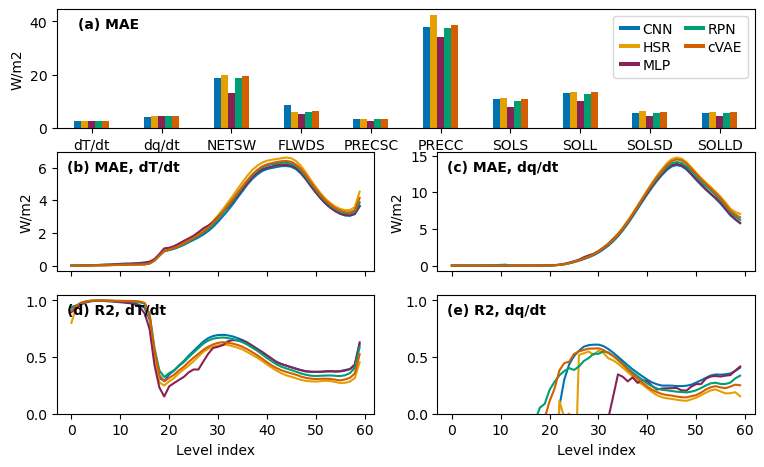

In [120]:
sw_log = False

abc='abbcdefghij'
# fig, _ax = plt.subplots(ncols=2, nrows=4,
#                         gridspec_kw={'height_ratios': [1.6,1,1,1]})

fig, _ax = plt.subplots(ncols=2, nrows=3)
gs = _ax[0, 0].get_gridspec()
# remove the underlying axes
for ax in _ax[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, 0:])



# top rows

plot_this_models = ['CNN','HSR','MLP','RPN','cVAE']
plot_this_metrics = ['MAE']

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )


ax = axbig
plotdata = PLOTDATA_by_METRIC[plot_this_metrics[0]]
plotdata = plotdata.rename(columns=var_short_name)
plotdata = plotdata.transpose()
plotdata.plot.bar(color=[lc_model[kmodel] for kmodel in plot_this_models],
                  legend = False,
                  ax=ax)
ax.set_xticklabels(plotdata.index, rotation=0, ha='center')
ax.set_xlabel('')
# ax.set_title(f'({abc[k]}) {kmetric}')
ax.set_ylabel('W/m2')

ax.text(0.03, 0.93, f'(a) {kmetric}', horizontalalignment='left',
       verticalalignment='top', transform=ax.transAxes,
       fontweight='demi')

if sw_log:
    ax.set_yscale('log')

ax.legend(ncols=2,
          columnspacing=.8,
          labelspacing=.3,
          handleheight=.1,
          handlelength=1.5,
          handletextpad=.2,
          borderpad=.4,
          frameon=True,
          loc='upper right')

# bottom rows

plot_this_models = ['CNN','HSR','MLP','RPN','cVAE']
plot_this_metrics = ['MAE', 'R2']

var_idx = {}
var_idx['ptend_t'] = (0,60)
var_idx['ptend_q0001'] = (60,120)

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics_stacked[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )


for kk, kvar in enumerate(['ptend_t','ptend_q0001']):
    for k, kmetric in enumerate(plot_this_metrics):
        ax = _ax[k+1, 0 if kvar=='ptend_t' else 1]
        idx_start = var_idx[kvar][0]
        idx_end = var_idx[kvar][1]
        plotdata = PLOTDATA_by_METRIC[kmetric].iloc[:,idx_start:idx_end]
        if plotdata.columns[0] > 1:
            plotdata.columns = plotdata.columns - 60
        if kvar=='ptend_q0001':
            plotdata = plotdata.where(~np.isinf(plotdata),-999)
        plotdata.transpose()\
        .plot(color=[lc_model[kmodel] for kmodel in plot_this_models],
              legend=False,
              ax=ax,
             )


        #ax.set_title(f'({abc[k]}) {kmetric}')
        if k==0:
            ax.set_ylabel(f'W/m2')
            ax.set_xlabel('')
            ax.set_xticklabels('')
        elif k==1:
            ax.set_xlabel('Level index')


        ax.text(0.03, 0.93, f'({abc[kk+2*k+2]}) {kmetric}, {var_short_name[kvar]}', horizontalalignment='left',
               verticalalignment='top', transform=ax.transAxes,
               fontweight='demi')

        if sw_log:
            ax.set_yscale('log')

        # R2 ylim
        if  (kmetric=='R2'):
            ax.set_ylim(0,1.05)


    # # legend
    # _ax[0].legend(ncols=1, labelspacing=.3,
    #           handleheight=.07, handlelength=1.5, handletextpad=.2,
    #           borderpad=.3,
    #           loc='upper left')

fig.set_size_inches(9,1.75*3)


### new fig

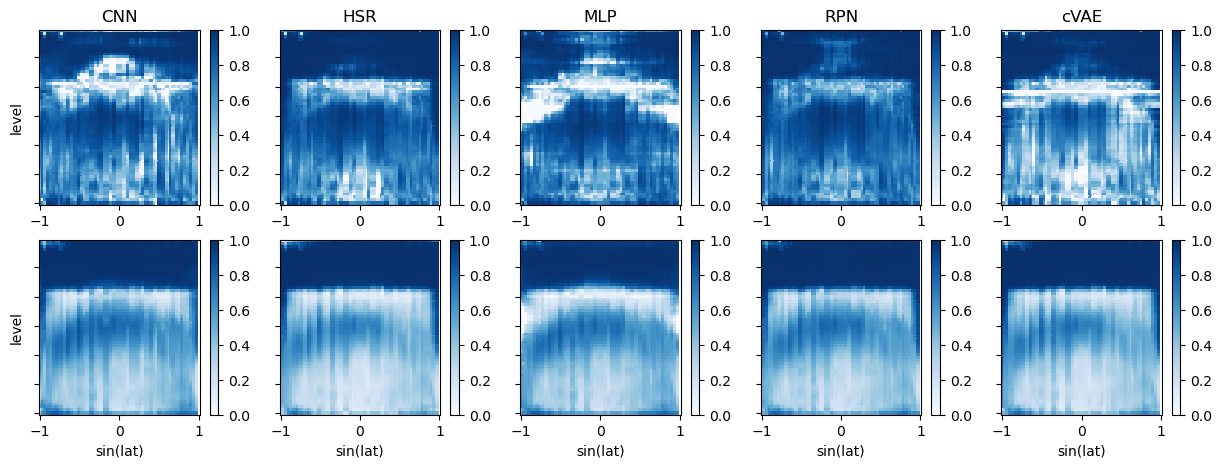

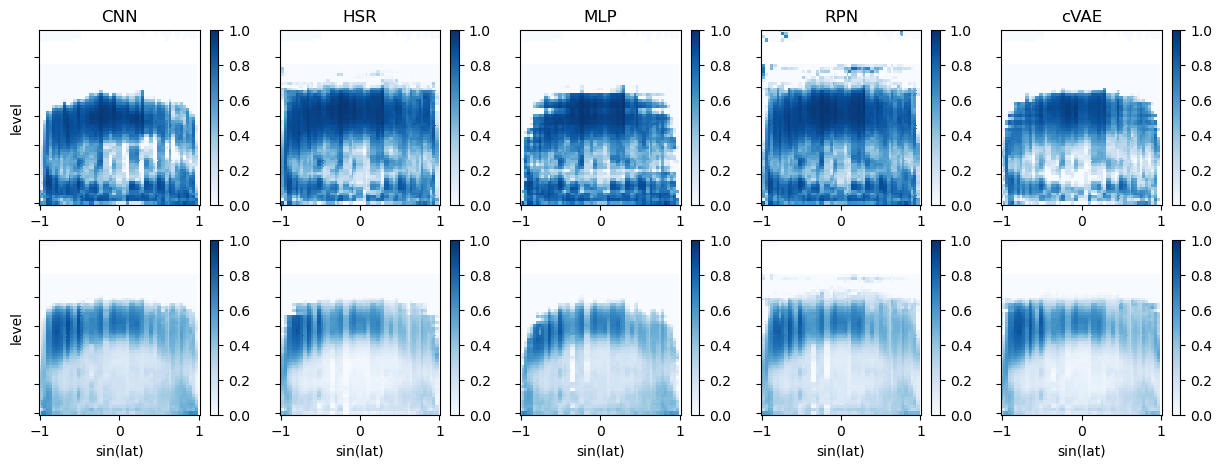

In [398]:

for kvar in ['ptend_t', 'ptend_q0001']:
    fig, _ax = plt.subplots(nrows=2, ncols=5)
    for k, kmodel in enumerate(plot_this_models):
        f_begin = f'./metrics/{kmodel}_R2_zonal-mean-in-the-beginning.nc'
        f_end   = f'./metrics/{kmodel}_R2_zonal-mean-at-the-end.nc'

        for kk, kf in enumerate([f_begin, f_end]):

            ax = _ax[kk,k]

            ds = xr.open_dataset(kf)
            plotdata = ds[kvar].transpose().values
            ploty = np.arange(1,61)
            plotx = np.sin(np.deg2rad(ds['lat']))
            h = ax.pcolor(plotx,ploty,plotdata,
                     vmin=0,vmax=1, cmap='Blues')
            ax.invert_yaxis()
            ax.set_ylabel('')
            ax.set_yticklabels('')
            plt.colorbar(h)

            if kk==0:
                ax.set_title(kmodel)

            if kk==1:
                ax.set_xlabel('sin(lat)')

            if k==0:
                ax.set_ylabel('level')


    fig.set_size_inches(15,5)